### Clasificación de Noticias Usando LSTM

#### Librerías

In [52]:
import pandas as pd
import openpyxl
import matplotlib.pyplot as plt
import re
import spacy
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, RegexpTokenizer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

#### 1. Carga y Exploración de Datos

In [53]:
Df = pd.read_excel("C:/Users/USER/OneDrive - universidadean.edu.co/5. NLP/Repositorio NLP/Actividad 2/Noticias.xlsx", engine='openpyxl')
Df.drop('Columna1', axis=1, inplace=True)
Df

,Enlaces,Título,info,contenido,Etiqueta
0,https://www.eltiempo.com/agresion-contra-un-op...,Operador de grúa quedó inconsciente tras agres...,El conductor de una moto le lanzó el casco y p...,Las autoridades están buscando al conductor de...,colombia
1,https://www.eltiempo.com/archivo/documento/CMS...,"Usaquén, primera en infracciones por mal parqueo",La localidad ocupa el primer lugar en comparen...,"""Los andenes son para los peatones"", reclama e...",archivo
2,https://www.eltiempo.com/archivo/documento/CMS...,'Me atracaron y vi un arma que me heló la sang...,Un ciudadano relata cómo cuatro hombres lo rob...,A las 7 de la noche me había quedado de encont...,archivo
3,https://www.eltiempo.com/archivo/documento/CMS...,"Escoltas mal estacionados, dolor de cabeza de ...",Las zonas de restaurantes se convierten en par...,Atravesados. Eso es lo que se les pasa por la ...,archivo
4,https://www.eltiempo.com/archivo/documento/CMS...,Radicado primer proyecto que autorizaría union...,"El representante de 'la U', Miguel Gómez, dijo...",“Estamos proponiendo la figura de un contrato ...,archivo
...,...,...,...,...,...
14391,https://www.eltiempo.com/vida/viajar/una-viaje...,Una viajera pensó que la aerolínea Viva Air le...,La mujer hizo la denuncia en redes. La aerolín...,En Twitter es tendencia 'FCAS' por una denunci...,vida
14392,https://www.eltiempo.com/vida/viajar/un-dia-pe...,"Un día perfecto en Coco Cay, la isla privada d...",El proyecto Global Private Island Collection c...,La naviera internacional Royal Caribbean prese...,vida
14393,https://www.eltiempo.com/vida/viajar/visitar-b...,Barú: el paraíso colombiano abierto para todos...,Cuatro hoteles y el Aviario Nacional lanzarán ...,¿Necesita razones para ir a Barú? A menos de u...,vida
14394,https://www.eltiempo.com/vida/viajar/we-trade-...,"Con WeTrade, llega la hora LGBT a Bogotá",El 1 y 2 de noviembre se celebrará esta Feria ...,Se estima que la población LGTBI en Colombia e...,vida


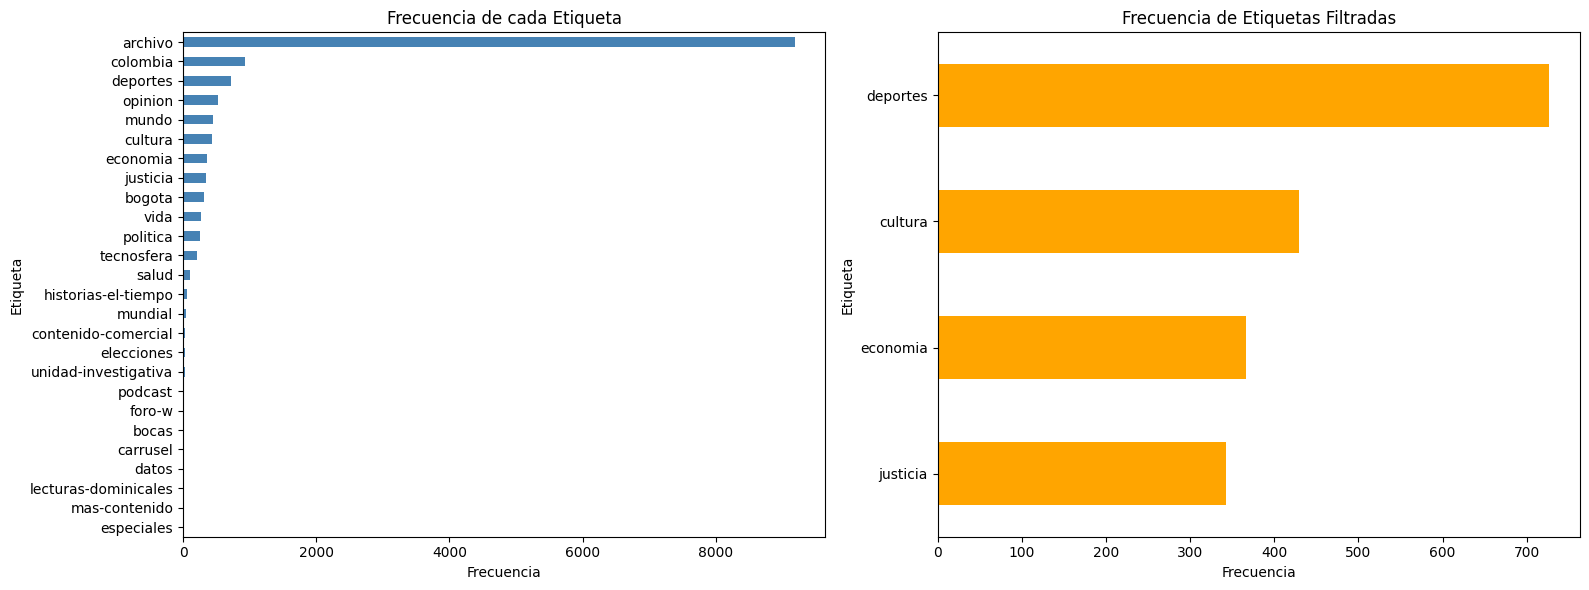

In [54]:
# Calcular las frecuencias
frecuencia_etiquetas = Df['Etiqueta'].value_counts()

# Crear los subgráficos en una sola fila
fig, axes = plt.subplots(1, 2, figsize=(16, 6))  # 1 fila, 2 columnas

# Graficar las frecuencias generales
frecuencia_etiquetas.plot(kind='barh', ax=axes[0], color='steelblue')
axes[0].set_title('Frecuencia de cada Etiqueta')
axes[0].set_xlabel('Frecuencia')
axes[0].set_ylabel('Etiqueta')
axes[0].invert_yaxis()  # Invertir el eje Y

# Filtrar etiquetas
Df_filter = Df[Df['Etiqueta'].isin(["deportes", "cultura", "economia", "justicia"])]
frecuencia_etiquetas_filter = Df_filter['Etiqueta'].value_counts()

# Graficar las frecuencias filtradas
frecuencia_etiquetas_filter.plot(kind='barh', ax=axes[1], color='orange')
axes[1].set_title('Frecuencia de Etiquetas Filtradas')
axes[1].set_xlabel('Frecuencia')
axes[1].set_ylabel('Etiqueta')
axes[1].invert_yaxis()  # Invertir el eje Y

# Ajustar diseño para evitar solapamientos
plt.tight_layout()
plt.show()



#### 2. Filtrado de Datos

In [55]:
#Eliminar contenido vacio
Df_filter = Df_filter.dropna(subset=['contenido'])

Df_filter


,Enlaces,Título,info,contenido,Etiqueta
10487,https://www.eltiempo.com/cultura/al-interior-d...,"Al interior de, aparte, roquero, rock / El len...",'Al interior de' es el reemplazo sofisticado e...,Citas: “Los crímenes de violencia sexual comet...,cultura
10488,https://www.eltiempo.com/cultura/arte-y-teatro...,Antonina Canal: 20 años de danza oriental en C...,La bailarina habló con EL TIEMPO de su trayect...,Con motivo de la celebración de los 20 años de...,cultura
10489,https://www.eltiempo.com/cultura/arte-y-teatro...,"Aparece en Holanda cuadro de Picasso, robado h...","La pintura era propiedad de un jeque saudí, Ab...","El cuadro Busto de mujer, del artista español ...",cultura
10490,https://www.eltiempo.com/cultura/arte-y-teatro...,Así será la programación del Carnaval de las A...,El evento con algunos de los artistas más repr...,"El Carnaval de las Artes, organizado en Barran...",cultura
10491,https://www.eltiempo.com/cultura/arte-y-teatro...,‘Fragmentos’ se viste de charlas y música,El lugar donde está el monumento de la artista...,"Louise du Toit, filósofa; el doctor Denis Mukw...",cultura
...,...,...,...,...,...
12467,https://www.eltiempo.com/justicia/servicios/po...,Más de 70 mil policías apoyan jornada de aisla...,Miisterio de Defensa activó dispositivo especi...,"El ministro de la Defensa, Carlos Holmes Truj...",justicia
12468,https://www.eltiempo.com/justicia/servicios/pr...,Habrá proyecto conjunto para superar la crisis...,Se revisarán “conductas antisociales” que se h...,Después de varios contrapunteos sobre la mejor...,justicia
12469,https://www.eltiempo.com/justicia/servicios/qu...,¿Qué hacer en caso de un accidente de tránsito...,EL TIEMPO y la Unilibre responden a esta y otr...,El TIempo y la Universidad Libre se aliaron pa...,justicia
12470,https://www.eltiempo.com/justicia/servicios/su...,Otorgan subsidios a tres obreros del edificio ...,También la esposa de una de las víctimas recib...,Tres trabajadores del edificio Portales Blas d...,justicia


Etiqueta
deportes    727
cultura     727
economia    727
justicia    727
Name: count, dtype: int64


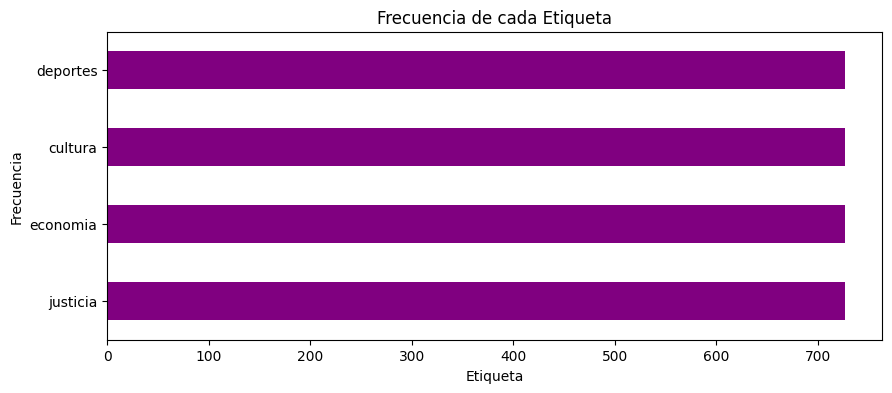

In [56]:
from sklearn.utils import resample

# Separar las clases
deportes = Df_filter[Df_filter['Etiqueta'] == 'deportes']
cultura = Df_filter[Df_filter['Etiqueta'] == 'cultura']
economia = Df_filter[Df_filter['Etiqueta'] == 'economia']
justicia = Df_filter[Df_filter['Etiqueta'] == 'justicia']

# Sobremuestreo de las clases menores
cultura_upsampled = resample(cultura, replace=True, n_samples=len(deportes), random_state=42)
economia_upsampled = resample(economia, replace=True, n_samples=len(deportes), random_state=42)
justicia_upsampled = resample(justicia, replace=True, n_samples=len(deportes), random_state=42)

# Unir los datasets
Df_pre = pd.concat([deportes, cultura_upsampled, economia_upsampled, justicia_upsampled])

#Graficar frecuencia
frecuencia_etiquetas = Df_pre['Etiqueta'].value_counts()

# Verificar el balance
print(Df_pre['Etiqueta'].value_counts())
plt.figure(figsize=(10, 4))
frecuencia_etiquetas.plot(kind='barh', color='purple')
plt.title('Frecuencia de cada Etiqueta')
plt.xlabel('Etiqueta')
plt.ylabel('Frecuencia')
plt.gca().invert_yaxis()
plt.show()

Se duplicaron los datos en el dataset para balancear las etiquetas y evitar que un conjunto de datos desbalanceado favorezca a las clases mayoritarias. Esta estrategia es especialmente útil en datasets pequeños, ya que permite al modelo identificar patrones relevantes en las clases minoritarias, mejorando su capacidad de generalización y equidad en la predicción.

#### 3. Preprocesamiento
#### 4. Division del conjunto de datos

In [57]:
Df_pre

,Enlaces,Título,info,contenido,Etiqueta
10924,https://www.eltiempo.com/deportes/automovilism...,La Fórmula 1 sigue sufriendo: aplazado el GP d...,Se debía celebrar del 12 al 14 de junio en Mon...,La organización del Grand Premio de Canadá de ...,deportes
10925,https://www.eltiempo.com/deportes/automovilism...,Al hijo de Schumacher no le disgustaría enfren...,"Mick, heredero de la dinastía del siete veces ...",Llevar el apellido Schumacher es sinónimo de g...,deportes
10926,https://www.eltiempo.com/deportes/automovilism...,Alonso y Toyota conquistan por primera vez las...,El español hizo equipo con Sébastian Buemi y e...,"Fernando Alonso, acompañado por el suizo Sébas...",deportes
10927,https://www.eltiempo.com/deportes/automovilism...,Batalla abierta por el campeonato de F1: Hamil...,Valtteri Bottas de Mercedes y Kimi Raikonen de...,El británico Lewis Hamilton logró este domingo...,deportes
10928,https://www.eltiempo.com/deportes/automovilism...,¡Qué innovadores! La atractiva propuesta para ...,En medio de las suspensiones de las carreras p...,La Fórmula 1 realizará una competición virtual...,deportes
...,...,...,...,...,...
12387,https://www.eltiempo.com/justicia/investigacio...,Cuatro departamentos han invertido menos del 3...,Contraloría dice que 54 % de recursos para inv...,Más de la mitad de la plata disponible para in...,justicia
12434,https://www.eltiempo.com/justicia/investigacio...,"Un video, prueba reina de soborno en el Tribun...",El esposo de la magistrada que había denunciad...,La Fiscalía imputó este martes cargos al secre...,justicia
12396,https://www.eltiempo.com/justicia/investigacio...,Recuerdos de un excombatiente en la Guerra de ...,El Coronel en retiro dijo que 4253 hombres hi...,Desde hace años Corea del Sur ha donado a Colo...,justicia
12182,https://www.eltiempo.com/justicia/conflicto-y-...,Hijo de 'Tirofijo' entre los nuevos disidentes...,También reaparecieron otros exjefes de las ext...,En el video de 32 minutos grabado por algunos ...,justicia


In [58]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import L1L2
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from nltk.corpus import stopwords
import spacy
import re
import nltk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Descargar stopwords de NLTK
nltk.download('stopwords')

# Cargar modelo de SpaCy
nlp = spacy.load('es_core_news_sm')

# 1. Clase para Normalizar el texto
class TextNormalizer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.stop_words = set(stopwords.words('spanish'))

    def normalize_text(self, text):
        text = text.lower()
        text = re.sub(r"[.,!?]", r" \g<0> ", text)  # Espacios antes y después de puntuación
        text = re.sub(r"[\W\d_]+", " ", text)  # Eliminar caracteres especiales y números
        text = " ".join([word for word in text.split() if word not in self.stop_words])  # Remover stopwords
        return text.strip()

    def transform(self, X, **kwargs):
        return X.apply(self.normalize_text)

    def fit(self, X, y=None, **kwargs):
        return self

# 2. Clase para Lematizar el texto
class TextLemmatizer(BaseEstimator, TransformerMixin):
    def transform(self, X, **kwargs):
        return X.apply(lambda x: " ".join([token.lemma_ for token in nlp(x)]))

    def fit(self, X, y=None, **kwargs):
        return self

# 3. Clase para Codificar las etiquetas
class LabelEncoderTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.label_encoder = LabelEncoder()

    def fit(self, y):
        self.label_encoder.fit(y)
        return self

    def transform(self, y, **kwargs):
        labels_encoded = self.label_encoder.transform(y)
        return tf.keras.utils.to_categorical(labels_encoded, num_classes=len(self.label_encoder.classes_))

# 4. Clase para Tokenizar texto
class TextTokenizer(BaseEstimator, TransformerMixin):
    def __init__(self, num_words=10000, maxlen=100):
        self.tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=num_words)
        self.maxlen = maxlen

    def fit(self, X, y=None):
        self.tokenizer.fit_on_texts(X)
        return self

    def transform(self, X, **kwargs):
        sequences = self.tokenizer.texts_to_sequences(X)
        return tf.keras.preprocessing.sequence.pad_sequences(sequences, maxlen=self.maxlen, truncating='post')

    def get_word_index(self):
        return self.tokenizer.word_index

# Crear el Pipeline de procesamiento de texto
text_pipeline = Pipeline([
    ('normalizer', TextNormalizer()),
    ('lemmatizer', TextLemmatizer()),
    ('tokenizer', TextTokenizer(num_words=10000, maxlen=100))
])

# Procesar los datos del DataFrame
sentences = Df_pre['contenido']
labels = Df_pre['Etiqueta']

# Normalizar, lematizar y tokenizar las oraciones
X_processed = text_pipeline.fit_transform(sentences)

# Codificar las etiquetas
y_encoder = LabelEncoderTransformer()
y = y_encoder.fit_transform(labels)

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)



[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### 6. Implementación modelo LSTM

In [61]:
# Configurar el modelo LSTM
vocab_size = len(text_pipeline.named_steps['tokenizer'].get_word_index()) + 1
max_length = 100
regularizer = L1L2(l1=1e-5, l2=1e-4)

In [ ]:
from keras_tuner import RandomSearch

def build_model(hp):
    model = Sequential()

    # Capa Embedding
    model.add(Embedding(input_dim=vocab_size, output_dim=128, input_length=max_length))

    # Primera capa LSTM
    model.add(LSTM(
        units=hp.Int('lstm1_units', min_value=64, max_value=256, step=64),
        return_sequences=True,
        dropout=hp.Float('lstm1_dropout', min_value=0.2, max_value=0.5, step=0.1),
        recurrent_dropout=hp.Float('lstm1_recurrent_dropout', min_value=0.2, max_value=0.5, step=0.1),
        kernel_regularizer=L1L2(l1=hp.Choice('lstm1_l1', [0.0, 1e-5]),
                                l2=hp.Choice('lstm1_l2', [1e-4, 1e-3]))
    ))

    # Segunda capa LSTM
    model.add(LSTM(
        units=hp.Int('lstm2_units', min_value=32, max_value=128, step=32),
        return_sequences=False,
        dropout=hp.Float('lstm2_dropout', min_value=0.2, max_value=0.5, step=0.1),
        recurrent_dropout=hp.Float('lstm2_recurrent_dropout', min_value=0.2, max_value=0.5, step=0.1),
        kernel_regularizer=L1L2(l1=hp.Choice('lstm2_l1', [0.0, 1e-5]),
                                l2=hp.Choice('lstm2_l2', [1e-4, 1e-3]))
    ))

    # Capas Densas
    model.add(Dense(hp.Int('dense_units', min_value=16, max_value=64, step=16), activation='relu',
                    kernel_regularizer=L1L2(l1=hp.Choice('dense_l1', [0.0, 1e-5]),
                                            l2=hp.Choice('dense_l2', [1e-4, 1e-3]))))
    model.add(Dropout(hp.Float('dense_dropout', min_value=0.2, max_value=0.5, step=0.1)))

    # Capa de salida
    model.add(Dense(len(y_encoder.label_encoder.classes_), activation='softmax'))

    # Compilación del modelo
    model.compile(
        optimizer=Adam(learning_rate=hp.Choice('learning_rate', [0.0001, 0.0005, 0.001])),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# Configuración del tuner
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=20,
    executions_per_trial=1,
    directory='my_dir',
    project_name='lstm_tuning_multiple'
)

# Realizar búsqueda de hiperparámetros
tuner.search(
    X_train, y_train,
    validation_split=0.2,
    epochs=10,
    batch_size=64,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)]
)

# Resultados del tuner
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print("\nMejores hiperparámetros encontrados:")
print(f"Primera LSTM - Unidades: {best_hps.get('lstm1_units')}, Dropout: {best_hps.get('lstm1_dropout')}, Recurrent Dropout: {best_hps.get('lstm1_recurrent_dropout')}")
print(f"Segunda LSTM - Unidades: {best_hps.get('lstm2_units')}, Dropout: {best_hps.get('lstm2_dropout')}, Recurrent Dropout: {best_hps.get('lstm2_recurrent_dropout')}")
print(f"Dense - Unidades: {best_hps.get('dense_units')}, Dropout: {best_hps.get('dense_dropout')}")
print(f"Learning Rate: {best_hps.get('learning_rate')}")

'\nfrom keras_tuner import RandomSearch\n\ndef build_model(hp):\n    model = Sequential()\n\n    # Capa Embedding\n    model.add(Embedding(input_dim=vocab_size, output_dim=128, input_length=max_length))\n\n    # Primera capa LSTM\n    model.add(LSTM(\n        units=hp.Int(\'lstm1_units\', min_value=64, max_value=256, step=64),\n        return_sequences=True,\n        dropout=hp.Float(\'lstm1_dropout\', min_value=0.2, max_value=0.5, step=0.1),\n        recurrent_dropout=hp.Float(\'lstm1_recurrent_dropout\', min_value=0.2, max_value=0.5, step=0.1),\n        kernel_regularizer=L1L2(l1=hp.Choice(\'lstm1_l1\', [0.0, 1e-5]),\n                                l2=hp.Choice(\'lstm1_l2\', [1e-4, 1e-3]))\n    ))\n\n    # Segunda capa LSTM\n    model.add(LSTM(\n        units=hp.Int(\'lstm2_units\', min_value=32, max_value=128, step=32),\n        return_sequences=False,\n        dropout=hp.Float(\'lstm2_dropout\', min_value=0.2, max_value=0.5, step=0.1),\n        recurrent_dropout=hp.Float(\'lstm2_r

In [63]:

model_lstm = Sequential([
    Embedding(input_dim=vocab_size, output_dim=128, input_length=max_length),
    LSTM(64, return_sequences=True, dropout=0.2, recurrent_dropout=0.2, kernel_regularizer=regularizer),
    LSTM(64, dropout=0.4, recurrent_dropout=0.4, kernel_regularizer=regularizer),
    Dense(32, activation='relu', kernel_regularizer=regularizer),
    Dropout(0.4),
    Dense(len(y_encoder.label_encoder.classes_), activation='softmax')
])

# Compilar el modelo
optimizer = Adam(learning_rate=0.001)
model_lstm.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# EarlyStopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Entrenamiento
history = model_lstm.fit(
    X_train, y_train,
    validation_split=0.2,
    batch_size=64,
    epochs=20,
    verbose=1,
    callbacks=[early_stopping]
)

# Mostrar resumen del modelo
model_lstm.summary()

Epoch 1/20


c:\Users\USER\miniconda3\envs\entorno_npl_ean_py3.10\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 8s 128ms/step - accuracy: 0.2744 - loss: 1.4358 - val_accuracy: 0.4571 - val_loss: 1.1472
Epoch 2/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - accuracy: 0.5425 - loss: 1.0363 - val_accuracy: 0.7618 - val_loss: 0.6148
Epoch 3/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step - accuracy: 0.7174 - loss: 0.6532 - val_accuracy: 0.7318 - val_loss: 0.5274
Epoch 4/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - accuracy: 0.7713 - loss: 0.5032 - val_accuracy: 0.8069 - val_loss: 0.4530
Epoch 5/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 110ms/step - accuracy: 0.7922 - loss: 0.4823 - val_accuracy: 0.9099 - val_loss: 0.4098
Epoch 6/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - accuracy: 0.8941 - loss: 0.3753 - val_accuracy: 0.9292 - val_loss: 0.2690
Epoch 7/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 113ms/step - accuracy: 0.9418 - loss: 0.2865 - val_accuracy: 0.9464 - val_loss: 0.2547
Epoch 8/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step - accuracy: 0.9700 - loss: 0.1833 - val_accuracy: 0.9421 - val_

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ (None, 100, 128)       │     4,410,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 100, 64)        │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,485,038 (51.44 MB)

 Trainable params: 4,495,012 (17.15 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 8,990,026 (34.29 MB)

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step

Reporte de Clasificación (LSTM):
               precision    recall  f1-score   support

     cultura       0.91      0.90      0.90       154
    deportes       0.99      0.94      0.97       155
    economia       0.88      0.95      0.91       134
    justicia       0.96      0.96      0.96       139

    accuracy                           0.93       582
   macro avg       0.93      0.94      0.93       582
weighted avg       0.94      0.93      0.94       582


Métricas Adicionales (LSTM):
Accuracy: 0.9347
Precision: 0.9363
Recall: 0.9347
F1 Score: 0.9351


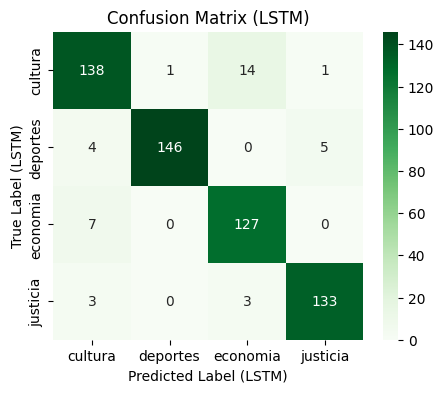

In [64]:
# Evaluar el modelo
y_pred_prob_lstm = model_lstm.predict(X_test)
y_pred_lstm = np.argmax(y_pred_prob_lstm, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

# Reporte de clasificación
report_lstm = classification_report(y_test_labels, y_pred_lstm, target_names=y_encoder.label_encoder.classes_)
print("\nReporte de Clasificación (LSTM):\n", report_lstm)

# Calcular métricas adicionales
accuracy_lstm = accuracy_score(y_test_labels, y_pred_lstm)
precision_lstm = precision_score(y_test_labels, y_pred_lstm, average='weighted')
recall_lstm = recall_score(y_test_labels, y_pred_lstm, average='weighted')
f1_lstm = f1_score(y_test_labels, y_pred_lstm, average='weighted')

print("\nMétricas Adicionales (LSTM):")
print(f"Accuracy: {accuracy_lstm:.4f}")
print(f"Precision: {precision_lstm:.4f}")
print(f"Recall: {recall_lstm:.4f}")
print(f"F1 Score: {f1_lstm:.4f}")

# Matriz de confusión
conf_matrix_lstm = confusion_matrix(y_test_labels, y_pred_lstm)
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix_lstm, annot=True, cmap='Greens', fmt='g', xticklabels=y_encoder.label_encoder.classes_, yticklabels=y_encoder.label_encoder.classes_)
plt.xlabel('Predicted Label (LSTM)')
plt.ylabel('True Label (LSTM)')
plt.title('Confusion Matrix (LSTM)')
plt.show()




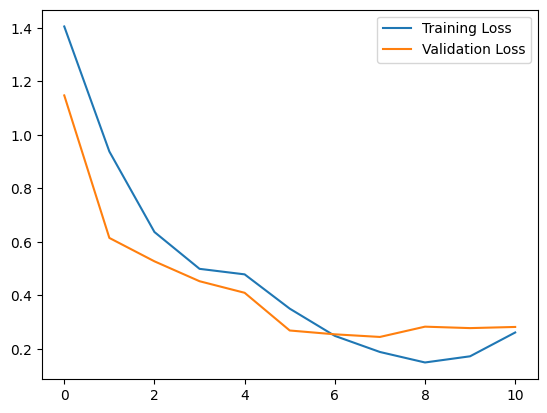

In [65]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()


In [69]:
nuevos_textos = [
    #Deporte
    "La selección nacional inició esta mañana su preparación para la próxima Copa Continental, que comenzará en dos semanas. Bajo las órdenes del nuevo entrenador, el conjunto ha intensificado las sesiones de entrenamiento, enfocándose en la mejora de la posesión del balón y el fortalecimiento de la defensa. Los aficionados se muestran optimistas, especialmente tras la incorporación de jóvenes promesas provenientes de las ligas menores.",
    #Cultura
    "Esta tarde se inaugura en el Museo Central la exposición “Reflejos Urbanos”, una muestra itinerante de arte contemporáneo que reúne obras de más de veinte artistas locales y extranjeros. La exhibición, abierta al público hasta finales de mes, combina pintura, escultura, fotografía y videoinstalaciones, todas ellas inspiradas en la interacción entre el ser humano y el entorno urbano. Se esperan visitas guiadas y charlas con los creadores durante los fines de semana.",
    #Economía
    "La principal bolsa del país cerró la semana con una leve subida del 1,2%, impulsada principalmente por el repunte de las acciones del sector tecnológico y energético. Analistas señalan que, pese a la incertidumbre global, los inversores mantienen la confianza en la solidez de la economía local. Asimismo, el ministerio de Hacienda anunció que continuará con las medidas de incentivos a las pequeñas y medianas empresas, con el fin de fortalecer el crecimiento sostenido.",
    #Justicia
    "Una magistrada del Juzgado Superior de la capital ordenó hoy la reapertura de un caso que había sido archivado el año pasado, alegando posibles irregularidades en la investigación policial. Según fuentes judiciales, se sospecha que ciertos informes forenses y testimonios clave no fueron debidamente analizados en la fase inicial del proceso. La defensa de la víctima, que llevaba meses exigiendo una revisión independiente, celebra la medida, mientras que las autoridades policiales han prometido colaborar plenamente para esclarecer los hechos. El nuevo juicio se espera que tenga lugar dentro de tres meses."
]

# Procesar los textos nuevos utilizando el pipeline
nuevo_texto_procesado = text_pipeline.transform(pd.Series(nuevos_textos))

# Realizar la predicción
prediccion_prob = model_lstm.predict(nuevo_texto_procesado)
prediccion_clase = np.argmax(prediccion_prob, axis=1)

# Obtener la etiqueta original
etiquetas_predicha = y_encoder.label_encoder.inverse_transform(prediccion_clase)

# Imprimir resultados para cada texto
for texto, etiqueta in zip(nuevos_textos, etiquetas_predicha):
    print(f"Texto: {texto}")
    print(f"Etiqueta predicha: {etiqueta}")
    print("--------------")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Texto: La selección nacional inició esta mañana su preparación para la próxima Copa Continental, que comenzará en dos semanas. Bajo las órdenes del nuevo entrenador, el conjunto ha intensificado las sesiones de entrenamiento, enfocándose en la mejora de la posesión del balón y el fortalecimiento de la defensa. Los aficionados se muestran optimistas, especialmente tras la incorporación de jóvenes promesas provenientes de las ligas menores.
Etiqueta predicha: deportes
--------------
Texto: Esta tarde se inaugura en el Museo Central la exposición “Reflejos Urbanos”, una muestra itinerante de arte contemporáneo que reúne obras de más de veinte artistas locales y extranjeros. La exhibición, abierta al público hasta finales de mes, combina pintura, escultura, fotografía y videoinstalaciones, todas ellas inspiradas en la interacción entre el ser humano y el entorno urbano. Se esperan visitas guiadas y charlas con los creadores durante los fines de semana.

#### Análisis de Resultados
**1. Matriz de Confusión**

El modelo muestra una alta precisión en todas las categorías, con una leve dificultad para distinguir entre cultura y economía. Este solapamiento sugiere que estas clases comparten características semánticas similares.

**2. Métricas de Evaluación**

Las métricas de precisión, recall y F1 superan 0.88 en todas las clases, destacando un equilibrio sólido entre identificación correcta y minimización de errores. Los promedios macro y weighted indican una buena generalización sin sesgo hacia ninguna categoría específica.

**3. Pérdida de Entrenamiento y Validación**

Ambas curvas de pérdida disminuyen consistentemente, señalando un aprendizaje efectivo. La leve diferencia entre entrenamiento y validación sugiere una buena capacidad de generalización sin sobreajuste.

**4. Evaluación en Nuevos Textos**

El modelo clasifica correctamente nuevos textos en todas las categorías, demostrando su capacidad para generalizar y manejar información no vista previamente con alta precisión.


#### Conclusión

El modelo LSTM exhibe un desempeño sólido y equilibrado en la clasificación de textos en cultura, deportes, economía y justicia. Con mejoras enfocadas en la diferenciación de categorías similares.